In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.signal import hilbert, butter, filtfilt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import random

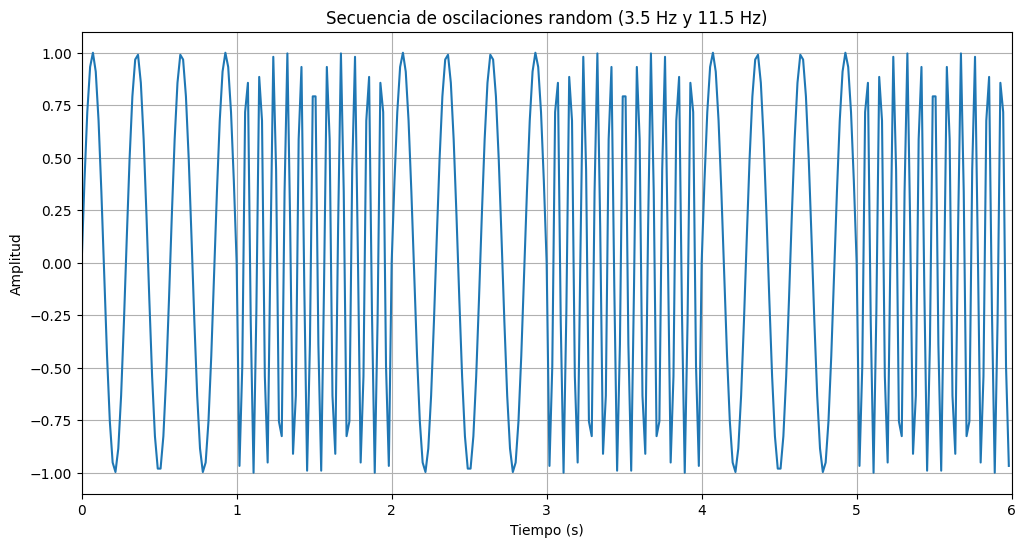

In [2]:
# Parámetros  
fs = 55            # Frecuencia de muestreo en Hz  
t_total = 6        # Duración total en segundos  
f1 = 3.5            # Frecuencia de la primera oscilación en Hz  
f2 = 11.5           # Frecuencia de la segunda oscilación en Hz  
duracion_segmento = 1  # Duración de cada segmento en segundos  
num_repeticiones = 6 # Número total de segmentos (3 de cada oscilacion) 

# vector de tiempo
t = np.arange(0, t_total, 1/fs) 

# Generamos las oscilaciones aleatorias   

amplitud = 1  # Amplitud aleatoria para la osc. 

# Inicializamos la secuencia  
secuencia = np.zeros_like(t)

# Llenar la secuencia con oscilaciones alternando  
for i in range(num_repeticiones):  
    if i % 2 == 0:  # Índices pares para la primera oscilación  
        start = i * duracion_segmento * fs  
        end = start + duracion_segmento * fs  
        secuencia[start:end] = amplitud  * np.sin(2 * np.pi * f1 * t[start:end])  
    else:  # Índices impares para la segunda oscilación  
        start = i * duracion_segmento * fs  
        end = start + duracion_segmento * fs  
        secuencia[start:end] = amplitud * np.sin(2 * np.pi * f2 * t[start:end])
# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t, secuencia)  
plt.title('Secuencia de oscilaciones random (3.5 Hz y 11.5 Hz)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

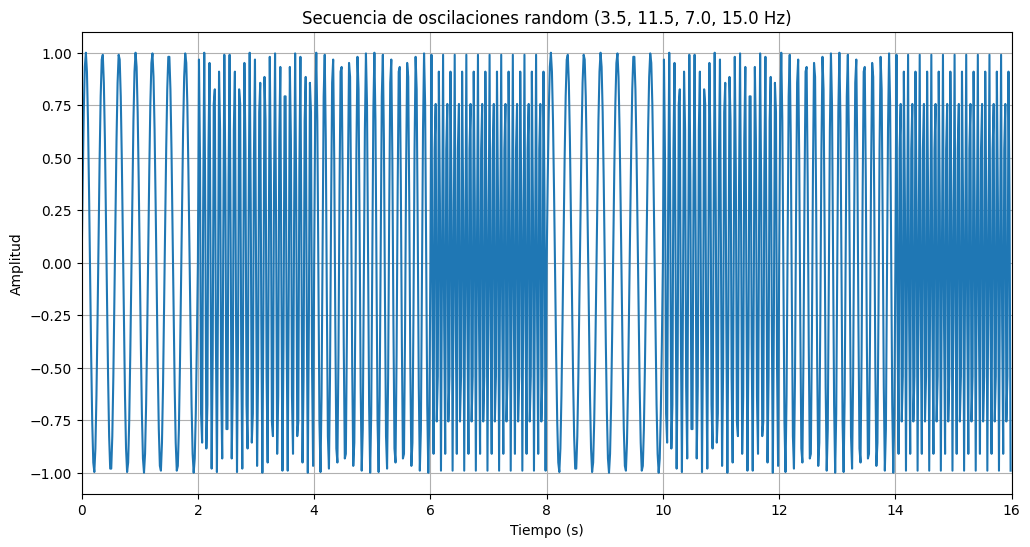

In [2]:
# Parámetros  
fs = 55            # Frecuencia de muestreo en Hz  
t_total = 16        # Duración total en segundos  
frecuencias = [3.5, 11.5, 7.0, 15.0]  # Cuatro frecuencias en Hz  
duracion_segmento = 2  # Duración de cada segmento en segundos  
num_repeticiones = 2 # 2 repeticiones = 16 segundos 

# Inicializamos la secuencia final como una lista  
secuencia2 = []  
amplitud = 1  

# Bucle externo para repetir el ciclo completo  
for i in range(num_repeticiones):  
    # Bucle interno para iterar sobre cada frecuencia en el ciclo  
    for frecuencia_idx in range(len(frecuencias)):  
        # Calcular el tiempo para el segmento actual  
        tiempo_segmento = np.arange(0, duracion_segmento, 1/fs)  
        
        # Calcular la frecuencia basada en el índice del segmento  
        frecuencia_actual = frecuencias[frecuencia_idx]  

        # Generar la oscilación según la frecuencia correspondiente  
        oscilacion = amplitud * np.sin(2 * np.pi * frecuencia_actual * tiempo_segmento)  

        secuencia2.extend(oscilacion)  # Añadir el segmento a la secuencia  

# Convertir la secuencia a un arreglo numpy para facilitar su manejo  
secuencia2 = np.array(secuencia2) 

# Crear el tiempo correspondiente a la secuencia  
t_compleja = np.arange(0, len(secuencia2)/fs , 1/fs)

# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t_compleja, secuencia2)  
plt.title('Secuencia de oscilaciones random (3.5, 11.5, 7.0, 15.0 Hz)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

## Clásico

In [3]:
# Parámetros
num_input_channels = 1      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 10   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = t.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

sec = secuencia.reshape(1, len(secuencia))

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        #(0.05 * input2res @ secuencia[i, np.newaxis]) +
        (0.05 * input2res @ sec[:, i]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS.shape)
analytic_signal = hilbert(RS)
amplitude_envelope = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS.shape)
print(amplitude_envelope.shape)

(10, 331)
(10, 331)
(10, 331)
(10, 331)


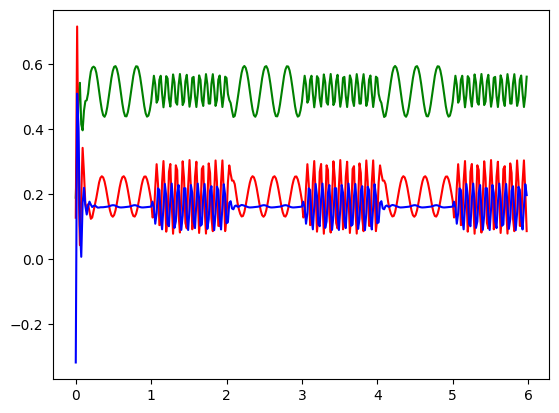

In [4]:
plt.plot(t, reservoir_states[0, 1:], color = 'green')
plt.plot(t, reservoir_states[1, 1:], color = 'red')
plt.plot(t, reservoir_states[2, 1:], color = 'blue')
plt.show()

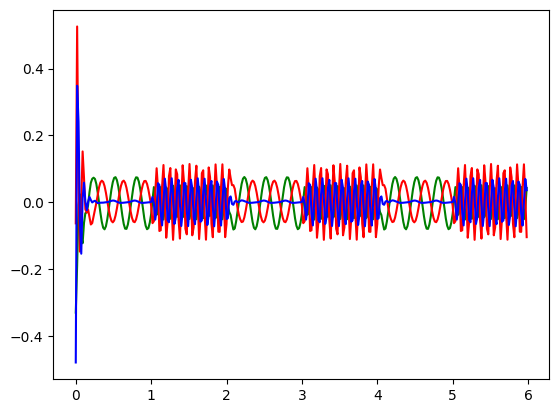

In [5]:
plt.plot(t, RS[0, 1:], color = 'green')
plt.plot(t, RS[1, 1:], color = 'red')
plt.plot(t, RS[2, 1:], color = 'blue')
plt.show()

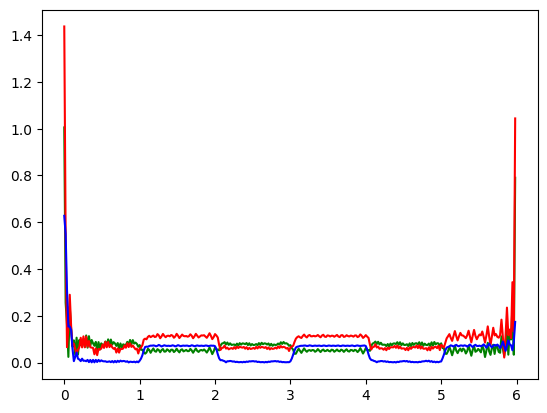

In [6]:
plt.plot(t, amplitude_envelope[0, 1:], color = 'green')
plt.plot(t, amplitude_envelope[1, 1:], color = 'red')
plt.plot(t, amplitude_envelope[2, 1:], color = 'blue')
plt.show()

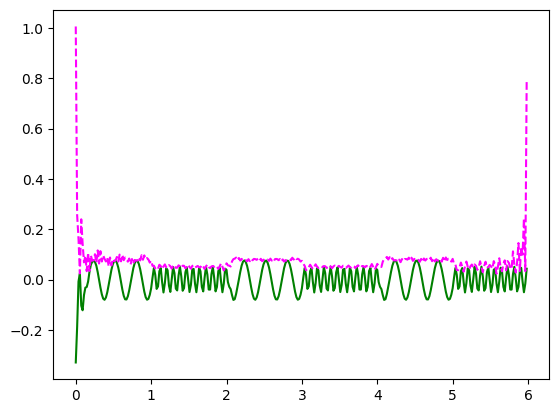

In [7]:
plt.plot(t, RS[0, 1:], color = 'green')
plt.plot(t, amplitude_envelope[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

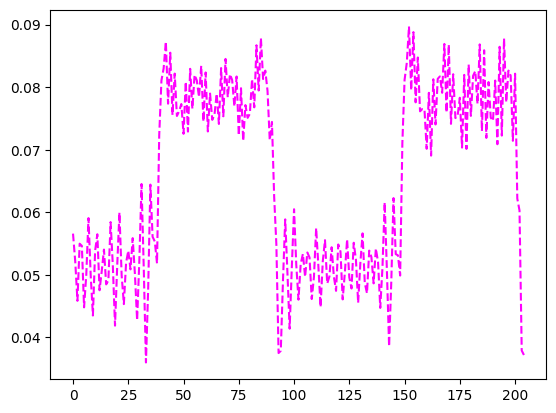

In [8]:
# Eliminamos los primeros 75 puntos para estabilizar el reservorio
stable_start = min(75, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
plt.plot(input_sequence[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [10]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.05076543 0.11239988 0.07074704 0.04181335 0.0356794  0.04219566
  0.05577467 0.14711234 0.0744288  0.00941628]
 [0.07717982 0.06400967 0.00551141 0.03423558 0.04802113 0.01382338
  0.06184437 0.08909634 0.0597231  0.01129127]]
(206,)


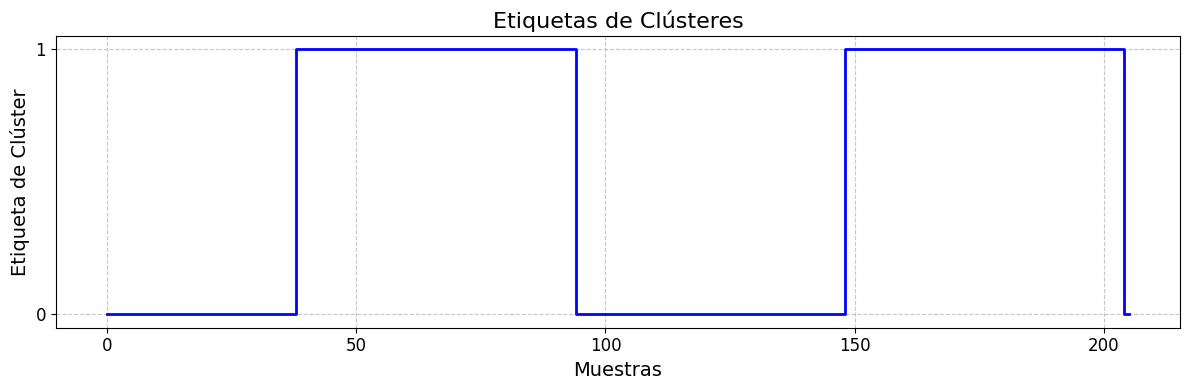

In [11]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## Cuántico

In [17]:
# Number of qubits (size of quantum reservoir)
num_qubits = 10
# Depth of the reservoir circuit
num_layers = 1  

# Create a quantum device (simulator)
dev = qml.device("default.qubit", wires=num_qubits)

In [4]:
def apply_RX(theta, state):  
    """Aplica la compuerta RX al estado dado en la qubit correspondiente."""  
    RX_matrix = np.array([[np.cos(theta / 2), -1j * np.sin(theta / 2)],  
                          [-1j * np.sin(theta / 2), np.cos(theta / 2)]])  
    # Numero total de qubits  
    dim = 2 ** num_qubits  
    
    # Crear una matriz identidad de dimensión total  
    full_matrix = np.eye(dim, dtype=complex)  
    
    # Insertar la matriz RX en la posición adecuada  
    for i in range(2 ** (num_qubits - 1)):  
        full_matrix[2*i, 2*i] = RX_matrix[0, 0]  
        full_matrix[2*i, 2*i + 1] = RX_matrix[0, 1]  
        full_matrix[2*i + 1, 2*i] = RX_matrix[1, 0]  
        full_matrix[2*i + 1, 2*i + 1] = RX_matrix[1, 1]  

    return np.dot(full_matrix, state) 

def apply_CNOT(state, control_index, target_index):  
    """Aplica la compuerta CNOT entre dos qubits en el estado dado."""  
    dim = 2 ** num_qubits  
    CNOT_matrix = np.eye(dim, dtype=complex)  
    # Crear la matriz CNOT  
    for i in range(dim):  
        binary = f"{i:0{num_qubits}b}"  
        control_qubit = int(binary[control_index])  # Estado del qubit de control  
        target_qubit = int(binary[target_index])     # Estado del qubit objetivo  

        # Si el qubit de control es 1, hacemos flip en el objetivo  
        if control_qubit == 1:  
            new_target_qubit = target_qubit ^ 1  # Flip  
            new_value = i & ~(1 << target_index) | (new_target_qubit << target_index)  
            CNOT_matrix[new_value, i] = 1  # Mover probabilidad de qubit viejo a nuevo  

    return np.dot(CNOT_matrix, state)  

def quantum_reservoir(reservoir_weights, num_qubits, initial_states):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""
    # Aplicar rotaciones y CNOTs    
    states = []
    for i in range(num_qubits):  
        # Rotación aleatoria en cada qubit  
        theta = reservoir_weights[i, i]
        state = apply_RX(theta, initial_states[i])  
        # Entrelazamiento con el siguiente qubit (circular)  
        target_qubit = (i + 1) % num_qubits  
        state = apply_CNOT(state, i, target_qubit) 
        states.append(state) 

    return states  

def compute_expectation_z(state):  
    """Calcula los valores de expectativa para cada qubit utilizando Z."""   
    dim = 2 ** num_qubits  # Dimensión total del espacio de Hilbert  

    # Iterar sobre cada qubit  
    for i in range(num_qubits):  
        # Crear la matriz Pauli-Z para el qubit i  
        Z_matrix = np.eye(dim, dtype=complex)  
        for j in range(dim):  
            binary = f"{j:0{num_qubits}b}"  
            # Si el qubit i es 1, cambia el signo  
            if binary[i] == '1':  
                Z_matrix[j, j] = -1  # Cambio de signo  

        # Calcular la expectativa  
        expectation_value = np.dot(state.conj().T, np.dot(Z_matrix, state)).real

    return expectation_value 

In [18]:
# Definir el Quantum Reservoir  
def quantum_reservoir(reservoir_weights):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            # Entrelazamiento con el siguiente qubit (circular)  
            control_qubit = i 
            target_qubit = (i + 1) % num_qubits  
            qml.CNOT(wires=[control_qubit, target_qubit])

In [19]:
# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights)
    
    # Measure expectation values (output features)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [59]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
#reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec = secuencia.reshape(1, len(secuencia))
input_series = sec
time_steps = input_series.shape[1]

# Run QESN
outputs = np.zeros((num_qubits, time_steps))
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_output = quantum_echo_state_network(input_series[:, t0], prev_output, weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_output)  # Apply tanh non-linearity

    # Almacenar el resultado en la lista
    outputs[:, t0] = np.array(final_output).squeeze()
    #outputs.append(final_output)
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {outputs[:, t0]}")

Step 0: [-0.02952863 -0.08930803  0.08047734 -0.05536552 -0.22098384  0.15393056
  0.01560367 -0.14330606  0.47873169  0.57347966]
Step 1: [-0.0643711  -0.12301204  0.07511425 -0.05658218 -0.20167562  0.15201632
  0.01341059 -0.15403899  0.63673553  0.6013175 ]
Step 2: [-0.09740547 -0.1339082   0.07427099 -0.05112939 -0.22417093  0.14552243
  0.01030084 -0.156705    0.6213195   0.60798817]
Step 3: [-0.12273196 -0.13724232  0.0735329  -0.04662873 -0.23212945  0.1409142
  0.00811095 -0.15813238  0.62419685  0.61155176]
Step 4: [-0.13662136 -0.13823609  0.07332626 -0.04480014 -0.23446408  0.13933429
  0.00731853 -0.15858421  0.62366099  0.61262031]
Step 5: [-0.13757868 -0.13845561  0.073676   -0.04610054 -0.22897993  0.14113293
  0.00806736 -0.15807161  0.62377733  0.61130617]
Step 6: [-0.12578754 -0.13836014  0.0745081  -0.05033206 -0.21673506  0.14593331
  0.01023331 -0.15660839  0.62380336  0.6075126 ]
Step 7: [-0.10273826 -0.13810345  0.07565328 -0.05677616 -0.19938333  0.15274667
  0

In [60]:
print(outputs.shape)
print(t.shape)

(10, 330)
(330,)


(10, 330)


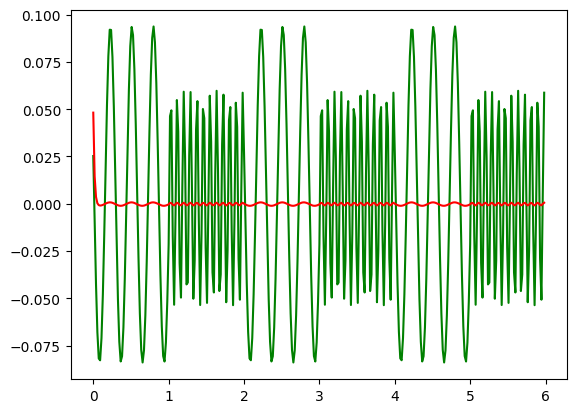

In [62]:
# Extracción de la envolvente superior usando Hilbert transform
RS_cuantico = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico.shape)

plt.plot(t, RS_cuantico[0, :], color = 'green')
plt.plot(t, RS_cuantico[1, :], color = 'red')
plt.show()

In [63]:
# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 1  # Frecuencia baja del filtro
highcut = 12  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS_cuantico, lowcut, highcut, fs)

In [65]:
analytic_signal = hilbert(x_filtered)
amplitude_envelope = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope.shape)

(10, 330)
(10, 330)


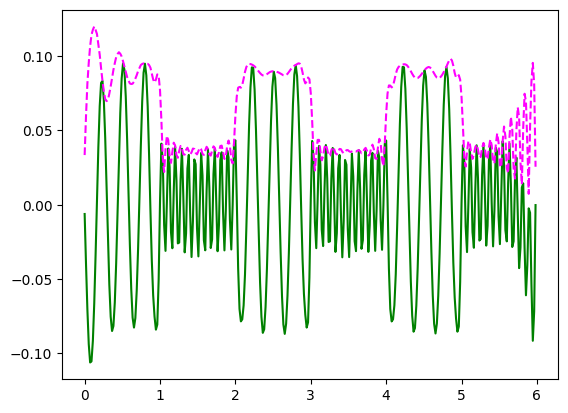

In [66]:
plt.plot(t, analytic_signal[0, :], color = 'green')
plt.plot(t, amplitude_envelope[0, :], linestyle="dashed", color = 'magenta')
plt.show()

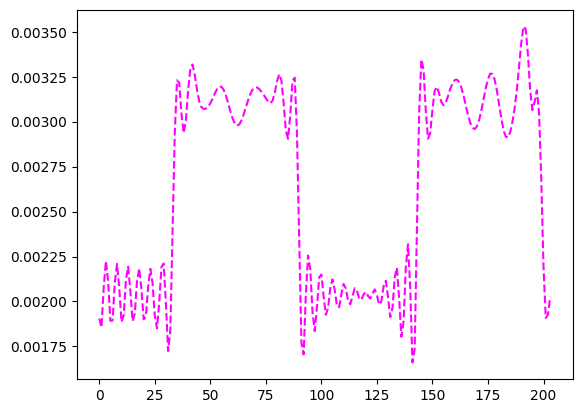

In [67]:
stable_start = min(75, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
plt.plot(input_sequence[2, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [68]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.0361672  0.0006761  0.00203056 0.0109117  0.0349386  0.01149641
  0.0056159  0.00489551 0.00142974 0.01458021]
 [0.08787429 0.00101938 0.00312255 0.01920299 0.05023866 0.01870373
  0.00941287 0.0079925  0.00156774 0.02347271]]
(205,)


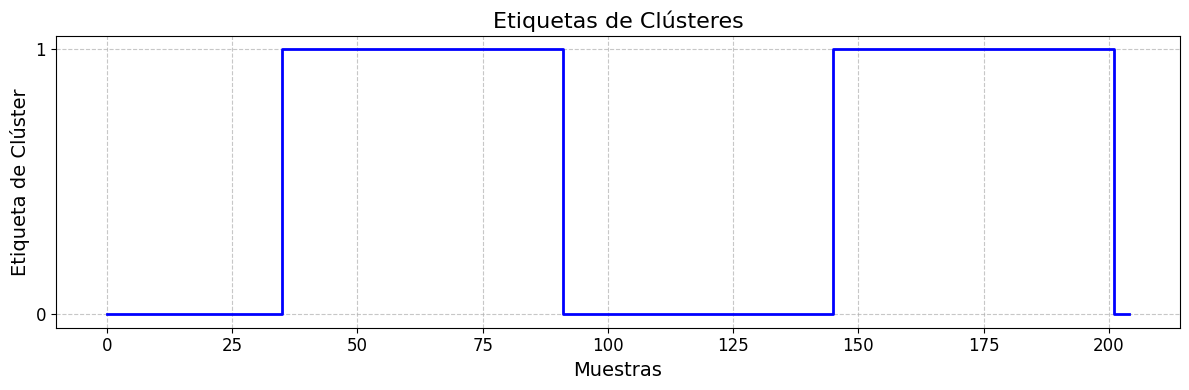

In [69]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## Señal senoidal más compleja(implementación clásica).

In [3]:
# Parámetros
num_input_channels = 1      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 30   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = t_compleja.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

sec2 = secuencia2.reshape(1, len(secuencia2))

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ sec2[:, i]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS2 = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS2.shape)

# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 15  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS2, lowcut, highcut, fs)

analytic_signal = hilbert(x_filtered)
amplitude_envelope2 = np.abs(analytic_signal)

print(analytic_signal.shape)
print(x_filtered.shape)
print(amplitude_envelope2.shape)

(30, 881)
(30, 881)
(30, 881)
(30, 881)


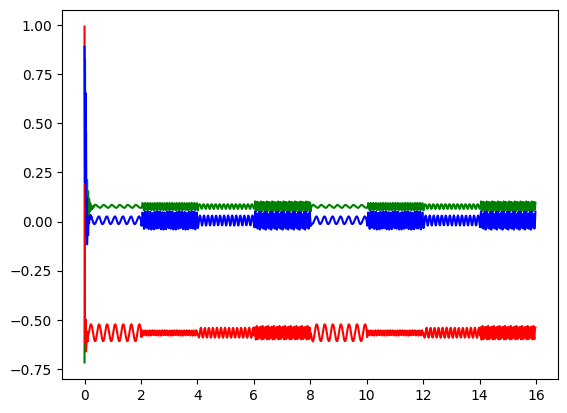

In [4]:
plt.plot(t_compleja, reservoir_states[0, 1:], color = 'green')
plt.plot(t_compleja, reservoir_states[1, 1:], color = 'red')
plt.plot(t_compleja, reservoir_states[2, 1:], color = 'blue')
plt.show()

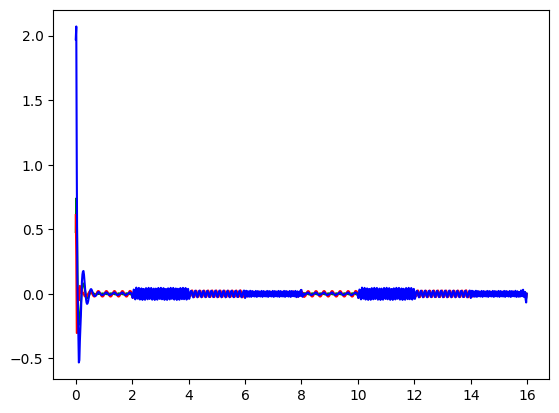

In [5]:
plt.plot(t_compleja, x_filtered[0, 1:], color = 'green')
plt.plot(t_compleja, x_filtered[1, 1:], color = 'red')
plt.plot(t_compleja, x_filtered[2, 1:], color = 'blue')
plt.show()

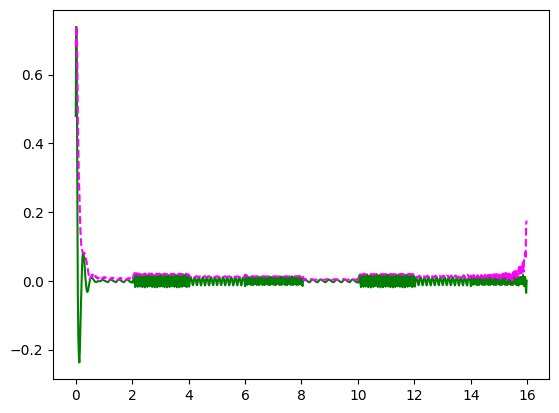

In [6]:
plt.plot(t_compleja, x_filtered[0, 1:], color = 'green')
plt.plot(t_compleja, amplitude_envelope2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

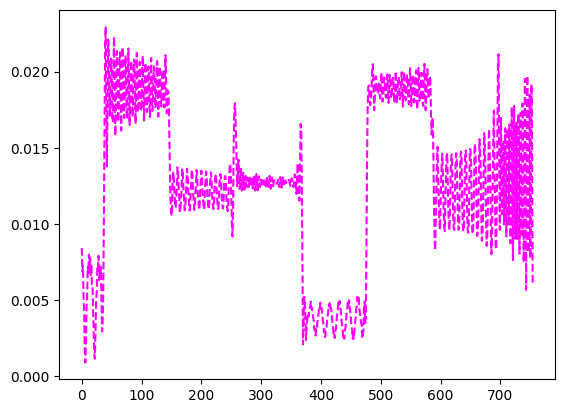

In [7]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(75, amplitude_envelope2.shape[1])
input_sequence2 = amplitude_envelope2[:, stable_start:-50]
plt.plot(input_sequence2[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [8]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence2.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.00438014 0.02184094 0.01113949 0.00819852 0.03468888 0.03195334
  0.0388548  0.00938413 0.01774123 0.00396301 0.00510027 0.02982679
  0.01226427 0.00552695 0.00474345 0.00989615 0.01665052 0.02580394
  0.01993102 0.0258437  0.02011399 0.00986668 0.01178836 0.02874219
  0.02192033 0.01611281 0.01703678 0.04332684 0.0018534  0.00590304]
 [0.01883849 0.01354849 0.04628138 0.01531213 0.0315897  0.0539792
  0.08170078 0.016788   0.02481743 0.01065204 0.03581338 0.06690838
  0.00337487 0.01694704 0.02343784 0.01935771 0.01763777 0.04008734
  0.04365452 0.08212246 0.03118392 0.04158322 0.02190589 0.03997534
  0.03378588 0.03517233 0.05715726 0.096155   0.00843465 0.00568359]
 [0.01202324 0.0256346  0.02638914 0.01923321 0.04989037 0.06185046
  0.08600439 0.01988024 0.0348972  0.00633867 0.01636663 0.0664649
  0.01138075 0.00300268 0.01470617 0.01991273 0.02532546 0.04353716
  0.04706052 0.06515921 0.02395515 0.02854854 0.02330052 0.04999801
  0.03974263 0.0351

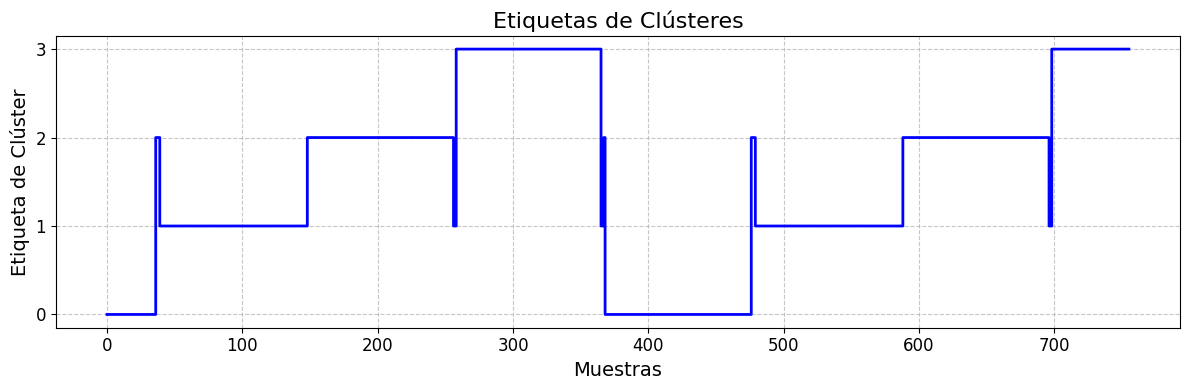

In [9]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence2.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

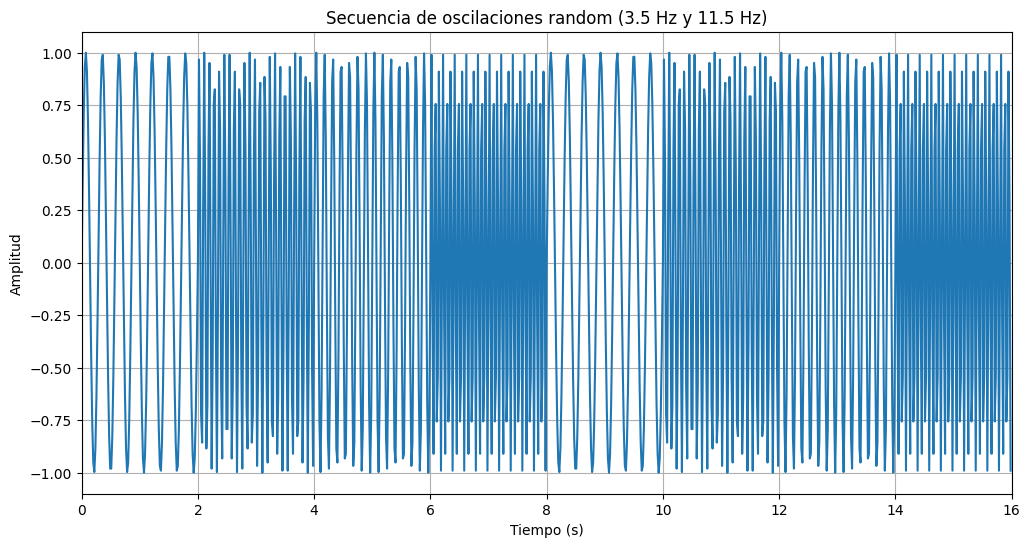

In [10]:
# Graficar la señal  
plt.figure(figsize=(12, 6))  
plt.plot(t_compleja, secuencia2)  
plt.title('Secuencia de oscilaciones random (3.5 Hz y 11.5 Hz)')  
plt.xlabel('Tiempo (s)')  
plt.ylabel('Amplitud')  
plt.xlim(0, t_total)  
plt.grid()  
plt.show()

## Señal senoidal más compleja(implementación cuántica).

In [11]:
# Number of qubits (size of quantum reservoir)
num_qubits = 10
# Depth of the reservoir circuit
num_layers = 1  

# Create a quantum device (simulator)
dev = qml.device("default.qubit", wires=num_qubits)

In [12]:
# Definir el Quantum Reservoir  
def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""    
    for i in range(num_qubits):
         for j in range(num_qubits):
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)
            
    # Aplicar entrelazamiento entre los qubits seleccionados.(conectividad limitada)
    if connectivity == 'ring':
        for j in range(num_qubits - 1):
            qml.CNOT(wires=[j, j+1])  # Apply entanglement between adjacent qubits
                     
                
    if connectivity == 'star':
    # Entangling the first qubit (central node) with all other qubits
        central_qubit = 0  # We use qubit 0 as the central node
        for j in range(1, num_qubits):
             qml.CNOT(wires=[central_qubit, j])
 
    if connectivity == 'random':
            # Crear pares de qubits aleatorios
              qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]
              random.shuffle(qubit_pairs)
            # Entrelazar aleatoriamente
              for j, k in qubit_pairs[:num_qubits // 2]:
                  qml.CNOT(wires=[j, k])
 
    elif connectivity == 'full':
            # Full connectivity: entangle all pairs of qubits
              for j in range(num_qubits):
                 for k in range(j + 1, num_qubits):  # Loop over all pairs of qubits
                    qml.CNOT(wires=[j, k])  # Apply entanglement between qubit j and k        

In [13]:
# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    # Measure expectation values (output features)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [14]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
#reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

sec2 = secuencia2.reshape(1, len(secuencia2))
input_series = sec2
time_steps = input_series.shape[1]

# Run QESN
outputs = np.zeros((num_qubits, time_steps))
prev_output = np.zeros(num_qubits)  # Initial output

for t0 in range(time_steps):
    q_output = quantum_echo_state_network(input_series[:, t0], prev_output, weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_output)  # Apply tanh non-linearity

    # Almacenar el resultado en la lista
    outputs[:, t0] = np.array(final_output).squeeze()
    prev_output = final_output  # Recurrent connection
    print(f"Step {t0}: {outputs[:, t0]}")

Step 0: [ 0.73137423  0.48271206  0.48244654  0.49368134  0.42581459  0.31348205
 -0.19724663 -0.42607442 -0.56151451  0.58320722]
Step 1: [ 0.69050148 -0.34317035 -0.38679234  0.72157982  0.50227033  0.22051806
 -0.05884573 -0.15060644 -0.75406042  0.71259219]
Step 2: [ 0.69658187  0.68806918  0.57843617  0.58640314  0.4971051   0.22878541
 -0.13408949 -0.29810331 -0.73774585  0.67681006]
Step 3: [ 0.69810802 -0.5749493  -0.6041912   0.72105416  0.49322282  0.23738042
 -0.07905995 -0.1770833  -0.74914061  0.67681718]
Step 4: [ 0.6986123   0.67540245  0.40876043  0.42793928  0.50033052  0.23997045
 -0.11174186 -0.23996137 -0.73525934  0.67274712]
Step 5: [ 0.6977638  -0.56430222 -0.62222295  0.72829498  0.4728606   0.23466697
 -0.09396187 -0.20991987 -0.74623683  0.67851479]
Step 6: [ 0.69568528  0.67743823  0.38670368  0.40078057  0.5088315   0.23190184
 -0.11329411 -0.26130444 -0.74638251  0.68407966]
Step 7: [ 0.69264786 -0.56960496 -0.636404    0.71131452  0.45273475  0.2112127
 -0

(10, 880)


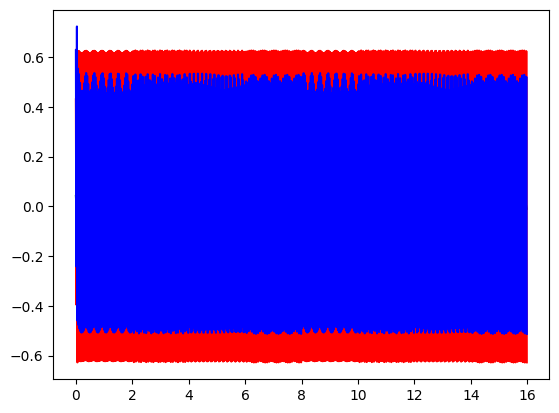

In [17]:
# Extracción de la envolvente superior usando Hilbert transform
RS_cuantico_2 = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_2.shape)

plt.plot(t_compleja, RS_cuantico_2[0, :], color = 'green')
plt.plot(t_compleja, RS_cuantico_2[1, :], color = 'red')
plt.plot(t_compleja, RS_cuantico_2[2, :], color = 'blue')
plt.show()

In [18]:
# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 55  # Frecuencia de muestreo
lowcut = 3.5  # Frecuencia baja del filtro
highcut = 16  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS_cuantico_2, lowcut, highcut, fs)

In [19]:
analytic_signal = hilbert(x_filtered)
amplitude_envelope = np.abs(analytic_signal)
print(analytic_signal.shape)
print(amplitude_envelope.shape)

(10, 880)
(10, 880)


(10, 755)


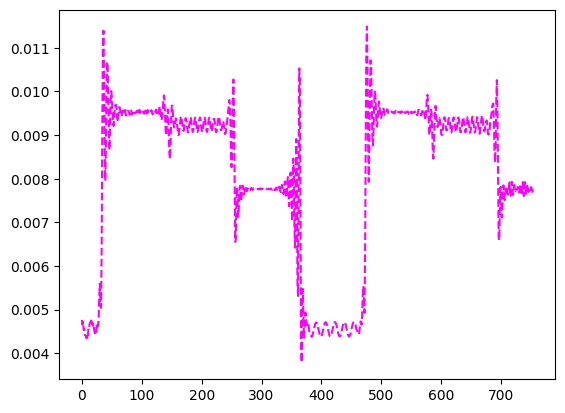

In [20]:
stable_start = min(75, amplitude_envelope.shape[1])
input_sequence = amplitude_envelope[:, stable_start:-50]
print(input_sequence.shape)
plt.plot(input_sequence[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [21]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.00463292 0.00191756 0.01430717 0.02812798 0.01109542 0.01788943
  0.00751771 0.04361038 0.00725226 0.01268682]
 [0.00781154 0.0066045  0.02911198 0.03601745 0.00961102 0.03420231
  0.0148632  0.08179222 0.00344383 0.02210907]
 [0.00941525 0.00481943 0.02696054 0.04809369 0.01903393 0.03868668
  0.01592673 0.09193718 0.00481414 0.02627129]
 [0.00765703 0.00376639 0.01376795 0.02701641 0.0183609  0.03371135
  0.01485805 0.08035581 0.00356453 0.02166052]]
(755,)


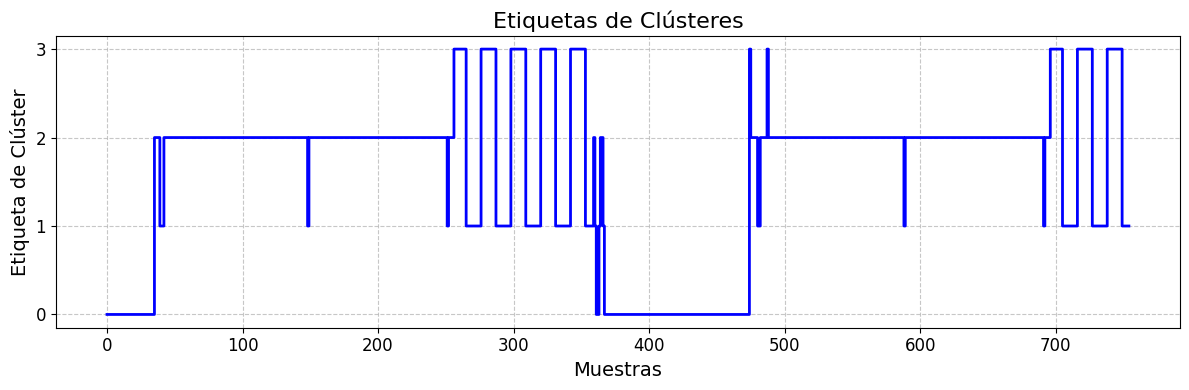

In [22]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()

## EEG reales.

In [13]:
# Carga de datos.
eeg_young = np.load("./data/data/dataset_Younger.npy")
eeg_old = np.load("./data/data/dataset_Older.npy")

In [ ]:
eeg_young.shape

(8, 2480, 65)

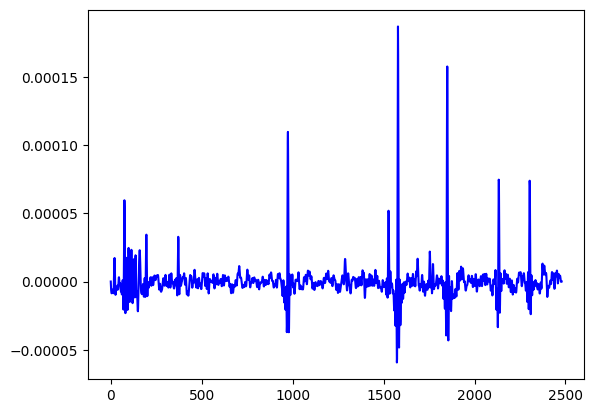

In [55]:
# Cogemos la señal de un canal de un sujeto joven.
muestra = eeg_young[0,:,:]

plt.plot(range(muestra.shape[0]), muestra[:,0], color = 'blue')
plt.show()

In [39]:
muestra2 = muestra[:,0:10]
muestra2.shape

(2480, 10)

In [48]:
# Implementación reservoir clásico con esta muestra.

# Parámetros
num_input_channels = 10      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 30   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = muestra2.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ muestra2[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS3 = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS3.shape)
analytic_signal = hilbert(RS3)
amplitude_envelope3 = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS3.shape)
print(amplitude_envelope3.shape)

(30, 2481)
(30, 2481)
(30, 2481)
(30, 2481)


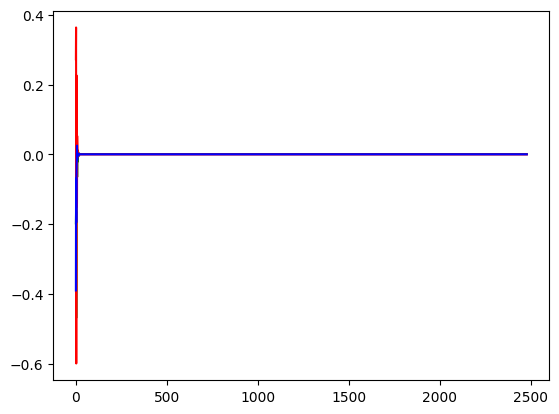

In [49]:
plt.plot(range(muestra.shape[0]), RS3[0, 1:], color = 'green')
plt.plot(range(muestra.shape[0]), RS3[1, 1:], color = 'red')
plt.plot(range(muestra.shape[0]), RS3[2, 1:], color = 'blue')
plt.show()

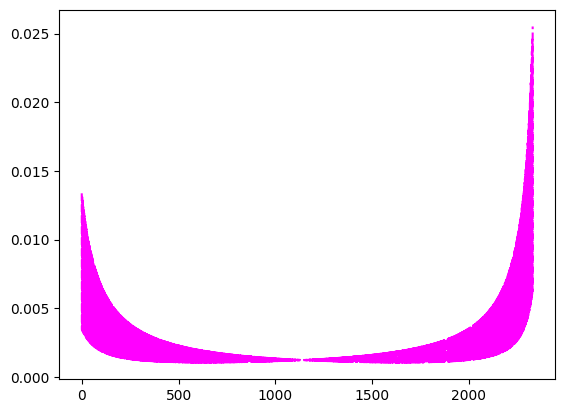

In [50]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(100, amplitude_envelope3.shape[1])
input_sequence3 = amplitude_envelope3[:, stable_start:-50]
plt.plot(input_sequence3[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [51]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence3.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.0015414  0.0004564  0.00062465 0.00090979 0.00167856 0.00133984
  0.00182389 0.00074577 0.00085667 0.00123208 0.00141169 0.00093719
  0.0001089  0.0006104  0.0010586  0.00127117 0.00199704 0.00243998
  0.00133267 0.00094674 0.0004207  0.00121244 0.00120079 0.00070906
  0.00195927 0.00029661 0.00157027 0.00020171 0.0008005  0.00131369]
 [0.01469658 0.00106077 0.00330633 0.00223084 0.01599283 0.0130219
  0.009583   0.00220115 0.00895932 0.00248636 0.01429208 0.0083798
  0.00078685 0.00056785 0.00779673 0.00582369 0.02071601 0.02322823
  0.01362455 0.00111897 0.00266732 0.01198134 0.00564589 0.00704977
  0.0160431  0.00223985 0.01311978 0.00158913 0.00115614 0.00926002]
 [0.0059926  0.00049487 0.0013651  0.00094244 0.00650621 0.00530596
  0.00393761 0.00091813 0.00359262 0.00115167 0.00585761 0.00335263
  0.00032453 0.00035945 0.00317362 0.0024136  0.00840883 0.0094139
  0.0055037  0.00060864 0.00112976 0.00491147 0.00231189 0.00282213
  0.00660209 0.00087

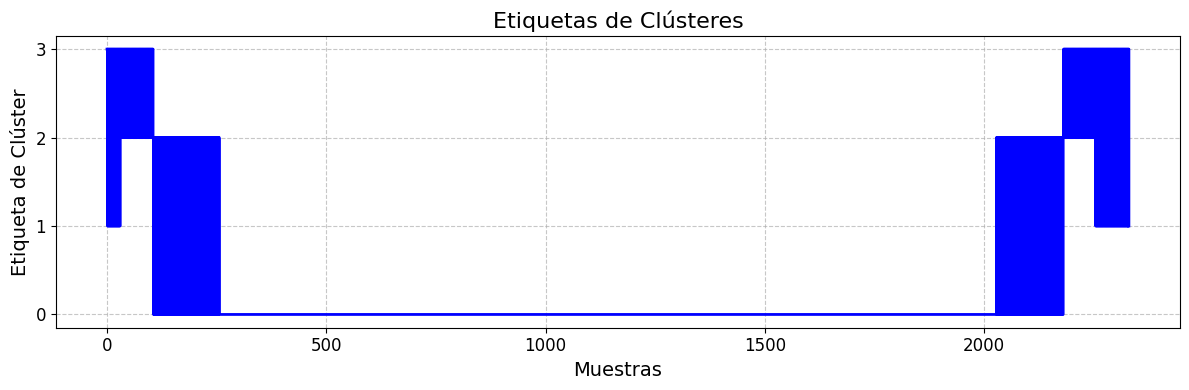

In [52]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence3.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([0,400])
plt.tight_layout() 
plt.show()

Número de clústeres: 2, Coeficiente Silhouette: 0.7830
Número de clústeres: 3, Coeficiente Silhouette: 0.7152
Número de clústeres: 4, Coeficiente Silhouette: 0.6475


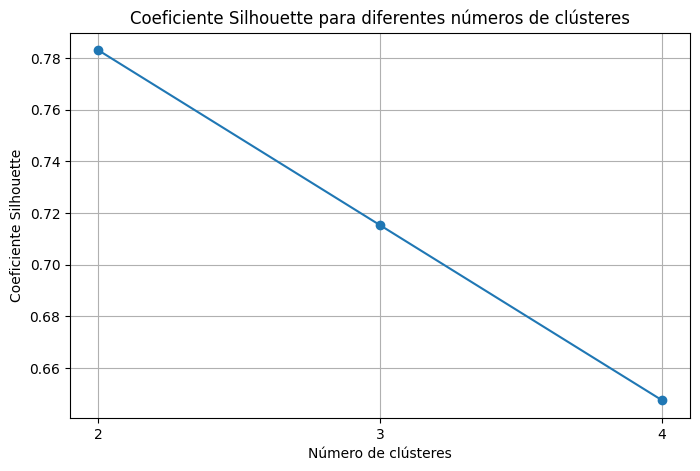

In [26]:
# Encontrar el número de estados del cerebro

silhouette_scores = []  
clusters_range = range(2, 5)  # Clústeres de 2 a 4  
labels_clusters = []

for num_clusters in clusters_range:  
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence3.T)  
    labels = kmeans.labels_  
    labels_clusters.append(labels)
    silhouette_avg = silhouette_score(input_sequence3.T, labels)  
    silhouette_scores.append(silhouette_avg)  
    print(f'Número de clústeres: {num_clusters}, Coeficiente Silhouette: {silhouette_avg:.4f}')  

# Graficar los resultados  
plt.figure(figsize=(8, 5))  
plt.plot(clusters_range, silhouette_scores, marker='o')  
plt.title('Coeficiente Silhouette para diferentes números de clústeres')  
plt.xlabel('Número de clústeres')  
plt.ylabel('Coeficiente Silhouette')  
plt.xticks(clusters_range)  
plt.grid()  
plt.show() 

## EEG simulados.

### Versión clásica.

In [26]:
synthetic_data = np.load('data/data/synthetic_data_auto.npy')
synthetic_data.shape

(40, 2000, 10)

In [27]:
muestra_synt = synthetic_data[0,:,:]
muestra_synt2 = synthetic_data[1,:,:]

In [28]:
# Reescalar la señal  
# Definimos el nuevo rango de -1 a 1.
min_val = -1  
max_val = 1  

# Calcular el rango original  
original_min = np.min(muestra_synt)  
original_max = np.max(muestra_synt)  

# Reescalar la señal  
scaled_signal = (muestra_synt - original_min) / (original_max - original_min) * (max_val - min_val) + min_val 

scaled_signal.shape

(2000, 10)

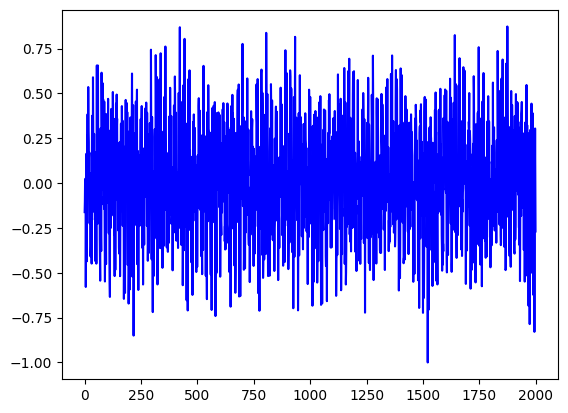

In [29]:
plt.plot(range(scaled_signal.shape[0]), scaled_signal[:,0], color = 'blue')
plt.show()

In [30]:
# Implementación reservoir clásico con EEG simulados.

# Parámetros
num_input_channels = 10      # Dimensionalidad de entrada (1 canal)
num_reservoir_neurons = 20   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = scaled_signal.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ scaled_signal[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS4 = reservoir_states - np.mean(reservoir_states,axis=1, keepdims=True)
print(RS4.shape)

# Función para aplicar un filtro pasa-banda
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Parámetros
fs = 512  # Frecuencia de muestreo
lowcut = 1  # Frecuencia baja del filtro
highcut = 12  # Frecuencia alta del filtro

# Aplicar filtro antes de Hilbert
x_filtered = bandpass_filter(RS4, lowcut, highcut, fs)

analytic_signal = hilbert(x_filtered)
amplitude_envelope4 = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS4.shape)
print(amplitude_envelope4.shape)

(20, 2001)
(20, 2001)
(20, 2001)
(20, 2001)


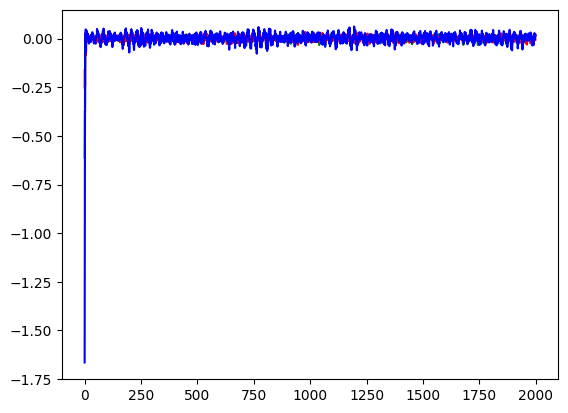

In [31]:
plt.plot(range(muestra_synt.shape[0]), RS4[0, 1:], color = 'green')
plt.plot(range(muestra_synt.shape[0]), RS4[1, 1:], color = 'red')
plt.plot(range(muestra_synt.shape[0]), RS4[2, 1:], color = 'blue')
plt.show()

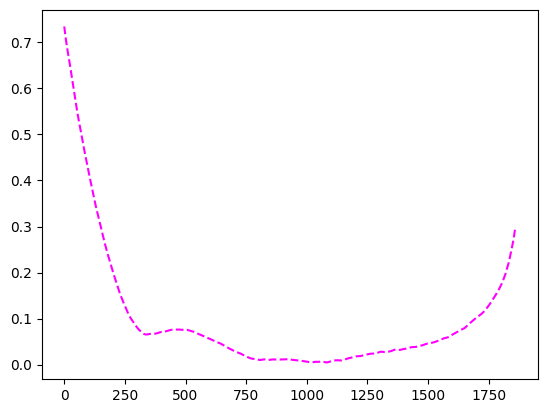

In [32]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(90, amplitude_envelope4.shape[1])
input_sequence4 = amplitude_envelope4[:, stable_start:-50]
plt.plot(input_sequence4[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [33]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence4.T)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

Centroides de los clústeres:
[[0.02294494 0.00813674 0.01758441 0.02276084 0.03387104 0.01616307
  0.02172327 0.01059628 0.03160523 0.01903435 0.00513679 0.00900744
  0.00864586 0.00456004 0.01669663 0.01647515 0.0154895  0.01182529
  0.012615   0.02710983]
 [0.56829352 0.19634293 0.43495523 0.51410928 0.83719268 0.39216531
  0.50682834 0.24457551 0.77142191 0.48991053 0.06253428 0.21083618
  0.16595326 0.11244789 0.38842022 0.40174369 0.35104491 0.29139119
  0.31180321 0.68900181]
 [0.26827048 0.09352493 0.2055631  0.25448159 0.39263328 0.1892337
  0.24668306 0.11882865 0.36757595 0.223927   0.02617562 0.09493936
  0.08402445 0.05009314 0.18826064 0.18932938 0.16582995 0.13631871
  0.14631196 0.32257093]
 [0.08876471 0.02998293 0.06863154 0.07598702 0.13170268 0.06050039
  0.07704209 0.03655375 0.11891547 0.08288415 0.01430784 0.03475825
  0.02364341 0.02136126 0.06012471 0.06166995 0.05213644 0.0478066
  0.04931232 0.11158926]]
(1861,)


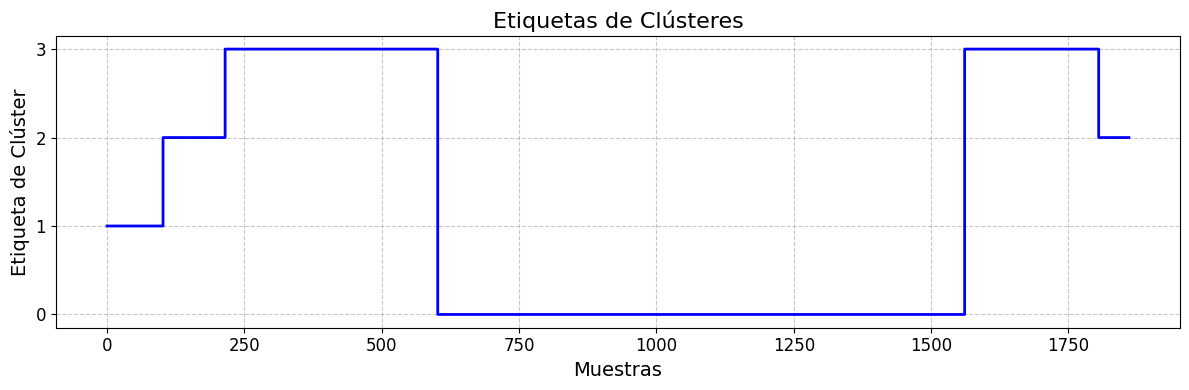

In [35]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence4.shape[1]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
#plt.xlim([0,200])
plt.tight_layout() 
plt.show()

### Versión cuántica.

In [56]:
# Hiperparámetros  
num_qubits = 10  # Ajustamos 10 qubit para cada canal 
dev = qml.device("default.qubit", wires=num_qubits)    
num_channels = 10 # tenemos 10 canales 


def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""  
    for i in range(num_qubits):  
         for j in range(num_qubits):  
            # Rotación aleatoria en cada qubit  
            qml.RX(reservoir_weights[i,j], wires= i)  

    # Aplicar entrelazamiento entre los qubits seleccionados.(conectividad limitada)  
    if connectivity == 'ring':  
        for j in range(num_qubits - 1):  
            qml.CNOT(wires=[j, j+1])  # Apply entanglement between adjacent qubits  


    if connectivity == 'star':  
    # Entangling the first qubit (central node) with all other qubits  
        central_qubit = 0  # We use qubit 0 as the central node  
        for j in range(1, num_qubits):  
             qml.CNOT(wires=[central_qubit, j])  

    if connectivity == 'random':  
            # Crear pares de qubits aleatorios  
              qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]  
              random.shuffle(qubit_pairs)  
            # Entrelazar aleatoriamente  
              for j, k in qubit_pairs[:num_qubits // 2]:  
                  qml.CNOT(wires=[j, k])  

    elif connectivity == 'full':  
            # Full connectivity: entangle all pairs of qubits  
              for j in range(num_qubits):  
                 for k in range(j + 1, num_qubits):  # Loop over all pairs of qubits  
                    qml.CNOT(wires=[j, k])  # Apply entanglement between qubit j and k 


# Define Quantum Node
@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN)"""
    # Encode input and previous output into qubits
    for i in range(num_qubits):
        qml.RX(.05*weights_in[i] * input_data + .95*weights_rc[i] * prev_output[i], wires=i)
    
    # Evolve through the quantum reservoir
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    # Measure expectation values (output features)
    return np.array([[qml.expval(qml.PauliZ(i))] for i in range(num_qubits)])

In [50]:
scaled_signal.shape

(2000, 10)

In [61]:
# Initialize parameters
weights_in = np.random.uniform(-np.pi, np.pi, num_qubits)
weights_rc = np.random.uniform(-np.pi, np.pi, num_qubits)
#reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

input_series = scaled_signal
time_steps = input_series.shape[1]

# Run QESN
outputs = np.zeros((num_qubits, time_steps, num_channels))
prev_output = np.zeros(num_qubits)  # Initial output

for i in range(num_channels):
    for t0 in range(time_steps):
        q_output = quantum_echo_state_network(input_series[t0, i], prev_output, weights_in, weights_rc, reservoir_weights)
        final_output = np.tanh(q_output)  # Apply tanh non-linearity

        # Almacenar el resultado en la lista
        outputs[:, t0, i] = np.array(final_output)
        prev_output = final_output  # Recurrent connection
        print(f"Step {t0}, Channel {i+1}: {outputs[:, t0, i]}")

TypeError: only integer scalar arrays can be converted to a scalar index

## Otra implementación cuántica.

In [103]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.quantum_info import random_unitary
from qiskit_aer import AerSimulator

from quantumreservoirpy.plot import feature_plotter
from quantumreservoirpy.reservoirs import Static

In [104]:
secuencia.shape

(330,)

In [143]:
num_qubits = 5
operator = random_unitary(2 ** num_qubits, seed=417)
backend = AerSimulator()

In [107]:
class QuantumReservoir(Static):

    def before(self, circuit):
        circuit.h(circuit.qubits)
    
    def during(self, circuit, timestep, reservoirnumber):
        circuit.initialize(int(timestep % 2), 1)
        circuit.append(operator, circuit.qubits)
        circuit.measure([0, 1])

In [144]:
quantum_res = QuantumReservoir(n_qubits=num_qubits, backend=backend)
quantum_data = quantum_res.run(timeseries=secuencia, shots=10000)

Running reservoirs: 100%|██████████| 1/1 [05:19<00:00, 319.65s/it]


(330, 2)


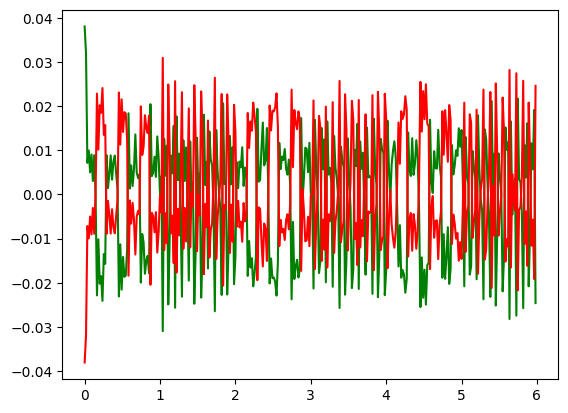

In [145]:
# Extracción de la envolvente superior usando Hilbert transform
RS_quant = quantum_data - np.mean(quantum_data,axis=1, keepdims=True)
print(RS_quant.shape)

plt.plot(t, RS_quant[:, 0], color = 'green')
plt.plot(t, RS_quant[:, 1], color = 'red')
plt.show()

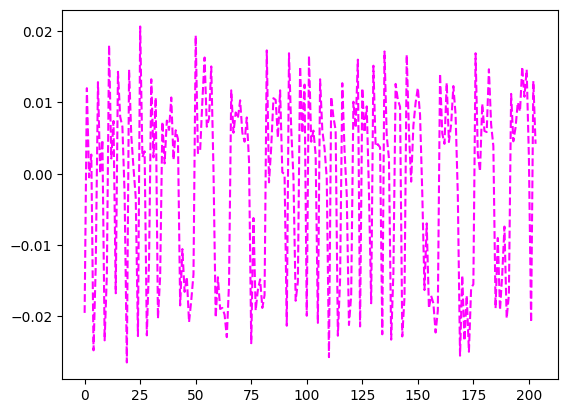

In [148]:
analytic_signal = hilbert(RS_quant)
amplitude_envelope = np.abs(analytic_signal)

# Eliminamos los primeros 75 puntos para estabilizar el reservorio
stable_start = min(75, analytic_signal.shape[0])
input_sequence = analytic_signal[stable_start:-50, :]
plt.plot(input_sequence[1:, 0], linestyle="dashed", color = 'magenta')
plt.show()

In [149]:
# Agrupamiento (clustering)
num_clusters = 2  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence)

# Resultados
idx = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx.shape)

ValueError: Complex data not supported
[[-1.200e-03+0.j  1.200e-03+0.j]
 [-1.950e-02+0.j  1.950e-02+0.j]
 [ 1.200e-02+0.j -1.200e-02+0.j]
 [-5.000e-04-0.j  5.000e-04+0.j]
 [ 2.700e-03+0.j -2.700e-03+0.j]
 [-2.475e-02+0.j  2.475e-02+0.j]
 [-1.280e-02+0.j  1.280e-02+0.j]
 [ 1.285e-02+0.j -1.285e-02+0.j]
 [ 5.000e-05+0.j -5.000e-05+0.j]
 [ 4.750e-03+0.j -4.750e-03-0.j]
 [-2.335e-02+0.j  2.335e-02+0.j]
 [-1.420e-02+0.j  1.420e-02+0.j]
 [ 1.805e-02+0.j -1.805e-02+0.j]
 [ 2.150e-03+0.j -2.150e-03+0.j]
 [ 7.400e-03+0.j -7.400e-03+0.j]
 [-1.675e-02-0.j  1.675e-02+0.j]
 [ 1.430e-02+0.j -1.430e-02+0.j]
 [ 8.000e-03+0.j -8.000e-03+0.j]
 [ 6.600e-03+0.j -6.600e-03+0.j]
 [-2.900e-03-0.j  2.900e-03+0.j]
 [-2.645e-02-0.j  2.645e-02+0.j]
 [ 1.460e-02+0.j -1.460e-02+0.j]
 [ 5.350e-03+0.j -5.350e-03+0.j]
 [ 8.000e-04+0.j -8.000e-04-0.j]
 [-3.300e-03+0.j  3.300e-03+0.j]
 [-2.275e-02-0.j  2.275e-02+0.j]
 [ 2.065e-02+0.j -2.065e-02+0.j]
 [ 2.350e-03+0.j -2.350e-03-0.j]
 [ 3.150e-03+0.j -3.150e-03+0.j]
 [-2.265e-02-0.j  2.265e-02+0.j]
 [-1.220e-02+0.j  1.220e-02+0.j]
 [ 1.325e-02+0.j -1.325e-02+0.j]
 [ 2.300e-03+0.j -2.300e-03+0.j]
 [ 1.070e-02+0.j -1.070e-02+0.j]
 [-2.030e-02-0.j  2.030e-02+0.j]
 [-1.435e-02+0.j  1.435e-02+0.j]
 [ 7.300e-03+0.j -7.300e-03+0.j]
 [ 1.450e-03+0.j -1.450e-03-0.j]
 [ 7.450e-03+0.j -7.450e-03+0.j]
 [ 6.150e-03+0.j -6.150e-03-0.j]
 [ 1.070e-02+0.j -1.070e-02+0.j]
 [ 1.950e-03+0.j -1.950e-03+0.j]
 [ 6.100e-03+0.j -6.100e-03+0.j]
 [ 4.900e-03+0.j -4.900e-03+0.j]
 [-1.845e-02-0.j  1.845e-02+0.j]
 [-1.055e-02+0.j  1.055e-02+0.j]
 [-1.655e-02-0.j  1.655e-02+0.j]
 [-1.445e-02+0.j  1.445e-02+0.j]
 [-2.080e-02+0.j  2.080e-02+0.j]
 [-1.775e-02-0.j  1.775e-02+0.j]
 [-1.410e-02+0.j  1.410e-02+0.j]
 [ 1.940e-02+0.j -1.940e-02-0.j]
 [ 2.900e-03+0.j -2.900e-03-0.j]
 [ 3.250e-03+0.j -3.250e-03+0.j]
 [ 1.020e-02+0.j -1.020e-02-0.j]
 [ 1.630e-02+0.j -1.630e-02+0.j]
 [ 6.600e-03+0.j -6.600e-03+0.j]
 [ 7.750e-03+0.j -7.750e-03+0.j]
 [ 1.505e-02+0.j -1.505e-02-0.j]
 [ 6.000e-04+0.j -6.000e-04+0.j]
 [-2.015e-02+0.j  2.015e-02+0.j]
 [-1.450e-02-0.j  1.450e-02+0.j]
 [-1.895e-02+0.j  1.895e-02+0.j]
 [-1.880e-02-0.j  1.880e-02+0.j]
 [-1.975e-02+0.j  1.975e-02+0.j]
 [-2.290e-02+0.j  2.290e-02+0.j]
 [-1.540e-02+0.j  1.540e-02+0.j]
 [ 1.170e-02+0.j -1.170e-02-0.j]
 [ 5.750e-03+0.j -5.750e-03+0.j]
 [ 8.600e-03+0.j -8.600e-03+0.j]
 [ 7.800e-03+0.j -7.800e-03+0.j]
 [ 1.030e-02+0.j -1.030e-02+0.j]
 [ 5.750e-03+0.j -5.750e-03+0.j]
 [ 4.500e-03+0.j -4.500e-03+0.j]
 [ 7.900e-03+0.j -7.900e-03+0.j]
 [ 1.800e-03+0.j -1.800e-03+0.j]
 [-2.375e-02-0.j  2.375e-02+0.j]
 [-6.200e-03-0.j  6.200e-03+0.j]
 [-1.915e-02+0.j  1.915e-02+0.j]
 [-1.625e-02+0.j  1.625e-02+0.j]
 [-1.480e-02+0.j  1.480e-02+0.j]
 [-1.880e-02+0.j  1.880e-02+0.j]
 [-1.700e-02-0.j  1.700e-02+0.j]
 [ 1.730e-02+0.j -1.730e-02+0.j]
 [-1.200e-03+0.j  1.200e-03+0.j]
 [ 3.750e-03+0.j -3.750e-03-0.j]
 [ 1.060e-02+0.j -1.060e-02+0.j]
 [ 1.035e-02+0.j -1.035e-02+0.j]
 [ 5.050e-03+0.j -5.050e-03-0.j]
 [ 1.170e-02+0.j -1.170e-02+0.j]
 [ 2.000e-04+0.j -2.000e-04+0.j]
 [-5.000e-05-0.j  5.000e-05+0.j]
 [-2.130e-02+0.j  2.130e-02+0.j]
 [ 1.690e-02+0.j -1.690e-02+0.j]
 [ 6.250e-03+0.j -6.250e-03+0.j]
 [-4.500e-04+0.j  4.500e-04+0.j]
 [-1.780e-02+0.j  1.780e-02+0.j]
 [-1.515e-02+0.j  1.515e-02+0.j]
 [ 1.505e-02+0.j -1.505e-02-0.j]
 [ 5.700e-03+0.j -5.700e-03+0.j]
 [ 1.250e-02+0.j -1.250e-02+0.j]
 [-1.990e-02+0.j  1.990e-02+0.j]
 [ 1.655e-02+0.j -1.655e-02+0.j]
 [ 4.500e-03+0.j -4.500e-03-0.j]
 [ 6.050e-03+0.j -6.050e-03+0.j]
 [ 2.650e-03+0.j -2.650e-03+0.j]
 [-2.090e-02+0.j  2.090e-02+0.j]
 [ 1.325e-02+0.j -1.325e-02-0.j]
 [ 6.100e-03+0.j -6.100e-03-0.j]
 [ 3.600e-03+0.j -3.600e-03+0.j]
 [-6.500e-04-0.j  6.500e-04+0.j]
 [-2.570e-02-0.j  2.570e-02+0.j]
 [ 1.080e-02+0.j -1.080e-02+0.j]
 [ 7.950e-03+0.j -7.950e-03-0.j]
 [ 6.100e-03+0.j -6.100e-03+0.j]
 [-2.270e-02-0.j  2.270e-02+0.j]
 [-1.485e-02-0.j  1.485e-02+0.j]
 [ 1.270e-02+0.j -1.270e-02+0.j]
 [ 3.300e-03+0.j -3.300e-03+0.j]
 [-2.950e-03-0.j  2.950e-03+0.j]
 [-2.120e-02-0.j  2.120e-02+0.j]
 [-1.700e-02+0.j  1.700e-02+0.j]
 [ 1.010e-02+0.j -1.010e-02+0.j]
 [ 6.450e-03+0.j -6.450e-03+0.j]
 [ 1.600e-02+0.j -1.600e-02+0.j]
 [-2.140e-02+0.j  2.140e-02+0.j]
 [ 1.200e-02+0.j -1.200e-02+0.j]
 [ 5.800e-03+0.j -5.800e-03+0.j]
 [ 9.450e-03+0.j -9.450e-03+0.j]
 [-2.600e-03+0.j  2.600e-03+0.j]
 [-1.815e-02+0.j  1.815e-02+0.j]
 [ 1.515e-02+0.j -1.515e-02+0.j]
 [ 3.850e-03+0.j -3.850e-03-0.j]
 [ 4.150e-03+0.j -4.150e-03+0.j]
 [ 3.700e-03+0.j -3.700e-03+0.j]
 [-2.250e-02+0.j  2.250e-02+0.j]
 [ 1.715e-02+0.j -1.715e-02+0.j]
 [ 5.300e-03+0.j -5.300e-03-0.j]
 [ 2.150e-03+0.j -2.150e-03+0.j]
 [-2.325e-02+0.j  2.325e-02+0.j]
 [-1.390e-02+0.j  1.390e-02+0.j]
 [ 1.260e-02+0.j -1.260e-02+0.j]
 [ 1.040e-02+0.j -1.040e-02+0.j]
 [ 9.400e-03+0.j -9.400e-03+0.j]
 [-2.280e-02-0.j  2.280e-02+0.j]
 [-1.730e-02+0.j  1.730e-02+0.j]
 [ 1.670e-02+0.j -1.670e-02-0.j]
 [ 5.900e-03+0.j -5.900e-03-0.j]
 [-1.100e-03+0.j  1.100e-03+0.j]
 [ 6.750e-03+0.j -6.750e-03-0.j]
 [ 9.950e-03+0.j -9.950e-03+0.j]
 [ 1.205e-02+0.j -1.205e-02-0.j]
 [ 8.250e-03+0.j -8.250e-03+0.j]
 [-2.700e-03+0.j  2.700e-03+0.j]
 [-1.630e-02-0.j  1.630e-02+0.j]
 [-6.950e-03+0.j  6.950e-03+0.j]
 [-1.885e-02+0.j  1.885e-02+0.j]
 [-1.710e-02+0.j  1.710e-02+0.j]
 [-1.815e-02+0.j  1.815e-02+0.j]
 [-2.225e-02+0.j  2.225e-02+0.j]
 [-1.920e-02+0.j  1.920e-02+0.j]
 [ 1.405e-02+0.j -1.405e-02+0.j]
 [ 5.650e-03+0.j -5.650e-03+0.j]
 [ 4.200e-03+0.j -4.200e-03+0.j]
 [ 1.275e-02+0.j -1.275e-02-0.j]
 [ 4.450e-03+0.j -4.450e-03+0.j]
 [ 6.950e-03+0.j -6.950e-03+0.j]
 [ 1.230e-02+0.j -1.230e-02-0.j]
 [ 8.300e-03+0.j -8.300e-03+0.j]
 [-2.950e-03+0.j  2.950e-03+0.j]
 [-2.550e-02+0.j  2.550e-02+0.j]
 [-1.425e-02+0.j  1.425e-02+0.j]
 [-2.340e-02+0.j  2.340e-02+0.j]
 [-1.705e-02+0.j  1.705e-02+0.j]
 [-2.495e-02+0.j  2.495e-02+0.j]
 [-1.600e-02+0.j  1.600e-02+0.j]
 [-1.550e-02-0.j  1.550e-02+0.j]
 [ 1.690e-02+0.j -1.690e-02-0.j]
 [ 2.800e-03+0.j -2.800e-03+0.j]
 [ 3.500e-04+0.j -3.500e-04+0.j]
 [ 9.800e-03+0.j -9.800e-03+0.j]
 [ 6.000e-03+0.j -6.000e-03+0.j]
 [ 5.850e-03+0.j -5.850e-03+0.j]
 [ 1.465e-02+0.j -1.465e-02-0.j]
 [ 6.900e-03+0.j -6.900e-03+0.j]
 [ 3.900e-03+0.j -3.900e-03-0.j]
 [-1.885e-02+0.j  1.885e-02+0.j]
 [-9.000e-03+0.j  9.000e-03+0.j]
 [-1.910e-02+0.j  1.910e-02+0.j]
 [-1.410e-02+0.j  1.410e-02+0.j]
 [-7.400e-03+0.j  7.400e-03+0.j]
 [-2.025e-02-0.j  2.025e-02+0.j]
 [-1.695e-02+0.j  1.695e-02+0.j]
 [ 1.120e-02+0.j -1.120e-02+0.j]
 [ 4.550e-03+0.j -4.550e-03+0.j]
 [ 6.500e-03+0.j -6.500e-03-0.j]
 [ 1.000e-02+0.j -1.000e-02-0.j]
 [ 8.750e-03+0.j -8.750e-03+0.j]
 [ 1.500e-02+0.j -1.500e-02+0.j]
 [ 1.080e-02+0.j -1.080e-02-0.j]
 [ 1.460e-02+0.j -1.460e-02-0.j]
 [ 2.400e-03+0.j -2.400e-03+0.j]
 [-2.080e-02+0.j  2.080e-02+0.j]
 [ 1.300e-02+0.j -1.300e-02+0.j]
 [ 4.200e-03+0.j -4.200e-03+0.j]]


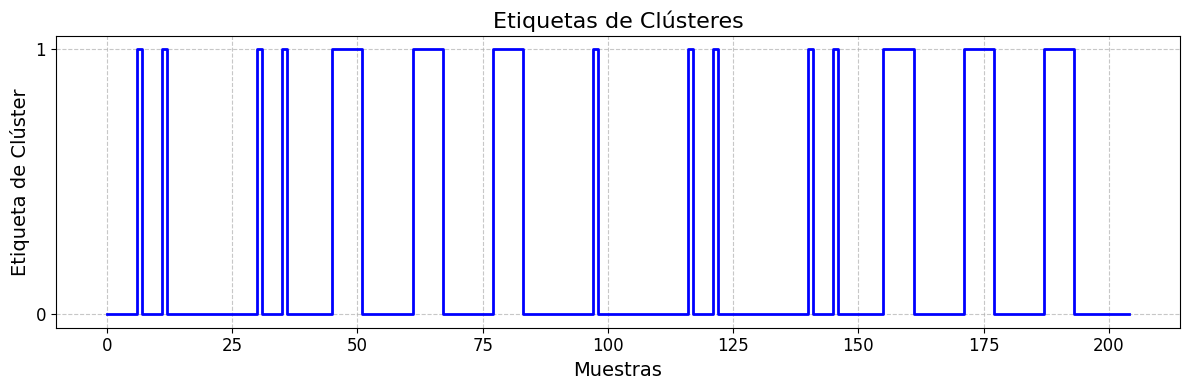

In [118]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence.shape[0]), idx, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(100, 200)  
plt.tight_layout() 
plt.show()